In [1]:
import warnings
import seaborn as sns
from sklearn_extra.cluster import KMedoids
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn import decomposition
import numpy as np
import pandas as pd
import sklearn
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
# Pour les biplot
from bioinfokit.visuz import cluster
from IPython import display
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering

from scipy import stats

#import matplotlib.pyplot as plt3D
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)
warnings.filterwarnings('ignore')


In [2]:
data = pd.read_csv('/Users/anis/test_labnbook/test_3_indicateurs/comparaison/comparaison.csv')
data = data.drop("Unnamed: 0", axis=1)
data.head()

,id_mission,id_report,id_labdoc,id_trace,n_users,n_mots,indice_collab,indice_collab_Anis,indice_contrib
0,1646,45234,445103,7475368,1,465,0.0,0.0,0.0
1,1646,45234,445103,7522660,1,616,0.0,0.0,0.0
2,1646,45234,445103,7647185,1,804,0.0,0.0,0.0
3,1646,45234,445103,7648145,1,804,0.0,0.0,0.0
4,1646,45234,445102,7477023,1,182,0.0,0.0,0.0


# Préparation du jeu de données

In [3]:
# Prendre la dernière trace de chaque labdoc
print("---- Prendre l'index de la dernière trace de chaque labdoc")
idx_labdocs = data['id_labdoc'].diff(
)[data['id_labdoc'].diff() != 0].index.values
idx_labdocs = np.delete(idx_labdocs, 0) - 1
df = data[data.index.isin(idx_labdocs)]

# Convertir les variables qualitative en chaîne de caractère
print("---- Convertir les variables qualitatives en string")
df.id_mission = df.id_mission.astype(str)
df.id_report = df.id_report.astype(str)
df.id_trace = df.id_trace.astype(str)
df.id_labdoc = df.id_labdoc.astype(str)

print("---- Enlever certaines colonnes")
df = df.drop(['id_report', 'id_trace', 'indice_collab'], axis=1)

print("---- Mettre l'id_labdoc dans l'index")
# Je met l'id_labdoc  dans les lignes
y = df['id_labdoc']

print("---- Enlever l'id_mission")
# Je vais enlever l'id_mission car selon moi c'est une variables qualitative qui ne peut pas intervenir dans l'ACP
df = df.drop(['id_mission', 'id_labdoc'], axis=1)
df.index = np.array(y)
df.head()

print("---- Enlever les labdoc avec un seul utilisateur")
# Enlever les labdocs avec un seul étudiant
df = df.drop(df[df['n_users'] == 1].index)

#df = df.drop("n_users", axis= 1 )
n, p = np.shape(df)
df.head()


---- Prendre l'index de la dernière trace de chaque labdoc
---- Convertir les variables qualitatives en string
---- Enlever certaines colonnes
---- Mettre l'id_labdoc dans l'index
---- Enlever l'id_mission
---- Enlever les labdoc avec un seul utilisateur


,n_users,n_mots,indice_collab_Anis,indice_contrib
445102,2,205,0.612223,0.450084
445109,2,449,0.222636,0.820115
445108,2,661,0.375491,0.620270
445104,2,261,0.137863,0.187721
445105,2,340,0.159027,0.628639


In [4]:
df.describe()

,n_users,n_mots,indice_collab_Anis,indice_contrib
count,428.000000,428.000000,428.000000,428.000000
mean,2.221963,138.161215,0.326463,0.504263
std,0.448556,151.755935,0.235670,0.260936
min,2.000000,3.000000,0.000000,0.000000
25%,2.000000,36.000000,0.140912,0.342545
50%,2.000000,74.500000,0.296253,0.494007
75%,2.000000,183.000000,0.476844,0.713593
max,4.000000,978.000000,0.977910,0.998042


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 428 entries, 445102 to 454202
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   n_users             428 non-null    int64  
 1   n_mots              428 non-null    int64  
 2   indice_collab_Anis  428 non-null    float64
 3   indice_contrib      428 non-null    float64
dtypes: float64(2), int64(2)
memory usage: 16.7+ KB


<AxesSubplot:>

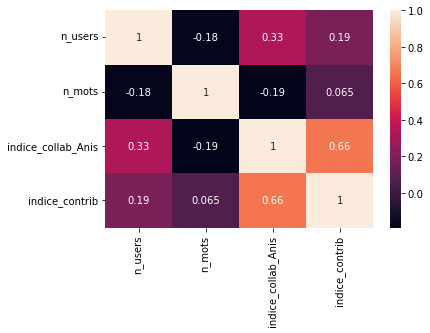

In [6]:
sns.heatmap(df.corr(), annot=True)

On remarque : 
* La variable nombre de mots n'est pas corrélée avec les autres variables 
* Les deux indicateurs sont fortement corrélées entre eux
* Une corrélation positive relativement faible entre le nombre d'utilisateurs et les deux indicateurs (curieux !)


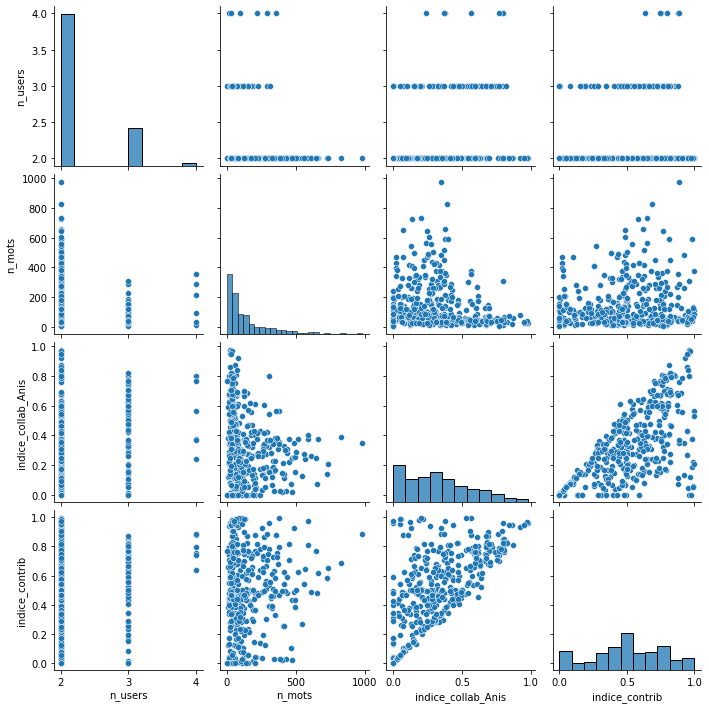

In [7]:
sns.pairplot(df)
plt.show()

In [8]:
freq_n_user_2 = 100*np.sum(df.n_users == 2)/n
freq_n_user_3 = 100*np.sum(df.n_users == 3)/n
freq_n_user_4 = 100*np.sum(df.n_users == 4)/n
print(freq_n_user_2,freq_n_user_3, freq_n_user_4)

79.20560747663552 19.39252336448598 1.4018691588785046


On remarque :
* On a peu de données sur des labdocs avec un nombre d'utilisateurs 3 et 4 
* L'indice de contribution et toujours au-dessus de l'indice de collaboration 
* Une bonne partie des labdocs à un nombre de mots entre 0 et 200 environs 
* Il y a clairement un déséquilibre dans le jeu de donnée, en termes de nombre, pour la variable nombre d'utilisateurs. En effet environs 80 % des labdocs on un nombre d'utilisateurs égale à 2 
contre 20‰ et 1.5 % pour 3 et 4. Ceci peut nuire à la classification.

# ACP 

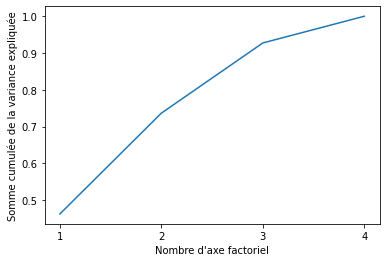

In [9]:
# Centrer et réduire les variables
X = df.copy() 
X_std = StandardScaler().fit_transform(X)
# ACP
n_components = 4
pca = decomposition.PCA(n_components)
X_projected = pca.fit_transform(X_std)

# Graphique de l'inertie total 
plt.plot(np.arange(1, p+1), np.cumsum(pca.explained_variance_ratio_))
plt.xticks(np.arange(1, p+1))
plt.xlabel("Nombre d'axe factoriel")
plt.ylabel('Somme cumulée de la variance expliquée')
plt.show()

On remarque que les deux premiers axe factoriel représentent environs 0.74 % de l'inertie totale. On va prendre que ces deux premiers axes.

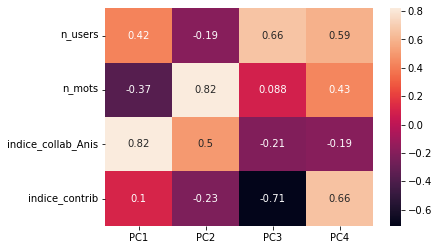

In [10]:
# Matrice des données projetées
X_projected = pd.DataFrame(X_projected, index=X.index, columns=[
                           "PC" + str(i+1) for i in range(n_components)])

# Corrélation entre les variables et les axes factorielles 
corr_df = pd.DataFrame(pca.components_, columns=X_projected.columns, index=X.columns)
ax = sns.heatmap(corr_df, annot=True)
plt.show()

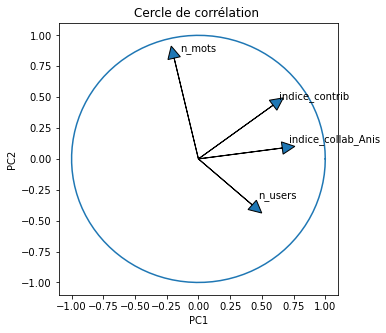

In [11]:
# Cercle de corrélation 
(fig, ax) = plt.subplots(figsize=(5, 5))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             pca.components_[0, i],  # 0 for PC1
             pca.components_[1, i],  # 1 for PC2
             head_width=0.1,
             head_length=0.1)

    plt.text(pca.components_[0, i] + 0.05,
             pca.components_[1, i] + 0.05,
             df.columns.values[i])


an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
ax.set_title('Cercle de corrélation ')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


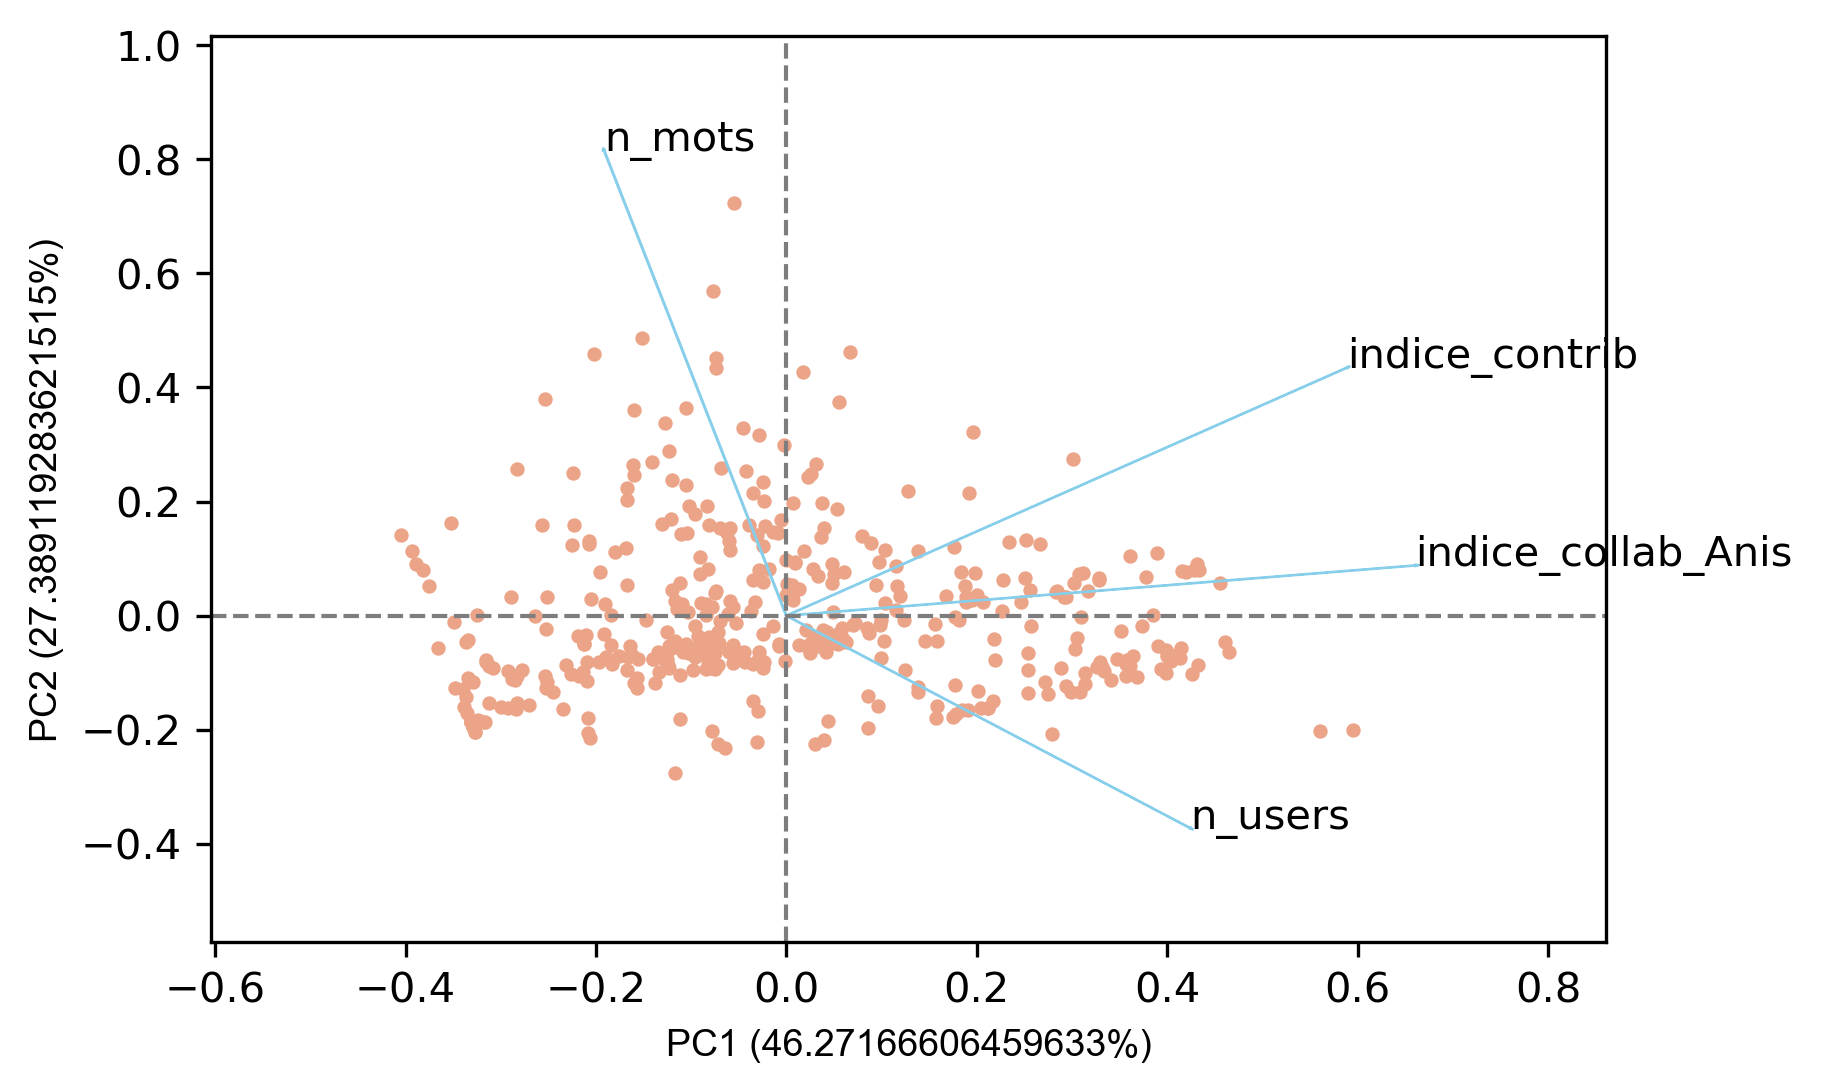

In [12]:
display.Image('/Users/anis/test_labnbook/test_3_indicateurs/comparaison/biplot_2d.png', width=500)

On remarque 
* Ce qui différencie les labdocs c'est l'axe PC2 qui est porté par la variable n_mots. On peut interpréter cette nouvelle variable PC2 comme la longueur d'un labdoc
* Il est moins évident d'interpréter l'axe PC1. Dans ce dernier  indice de collaboration y contribuent le plus. 
* Je dirais que les nouvelles variables sont la longueur du document (PC2) et l'indice de collaboration PC1


# Clustering 
## K-means 

Pour le clustering nous allons utiliser les données non corrélée issue de l'ACP

In [32]:
#data = pd.DataFrame(X_std, columns=X[:-1].columns)
#data = X
data = X_projected[["PC1","PC2"]]

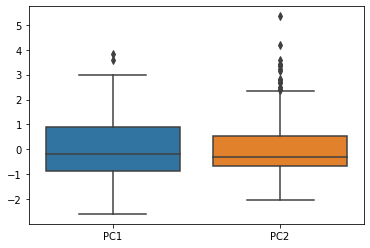

In [14]:
sns.boxplot(data = data)
plt.show()

* On remarque qu'il y a beaucoup de valeurs aberrantes. Ceci peut nuire à la classification 

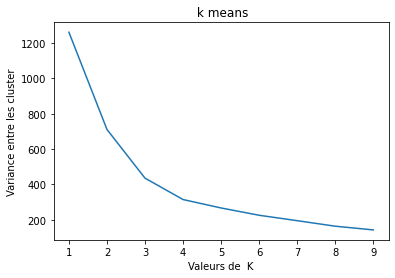

In [15]:
# Trouver le meilleur K
Sum_of_squared_distances = []
K = range(1, 10)
for num_clusters in K:
    model = KMeans(n_clusters=num_clusters)
    model.fit(data)
    Sum_of_squared_distances.append(model.inertia_)
plt.plot(K, Sum_of_squared_distances)
plt.xlabel('Valeurs de  K')
plt.ylabel('Variance entre les cluster')
plt.title(' k means')
plt.show()

Je vais choisir 3 cluster d'après la méthode du coude
le point du coude est celui du nombre de clusters à partir duquel la variance ne se réduit plus significativement

In [24]:
n_clusters = 3
model =  KMeans(n_clusters=n_clusters)
model.fit(data)

# Rajouter les labels au jeu de données initial
X["labels"] = model.labels_

In [25]:
# fig, ax = plt.subplots(len(X.columns[:-1]), n_clusters, figsize=(15, 15))
# colors= ['r','b','g','c','m']
# for i,var in enumerate(X.columns[:-1]):
#     for j in range(n_clusters):
#         ax[i, j].set_title("{} de la classe {}".format(var,j))
#         ax[i, j].hist((X[X["labels"] == j])[var],color=colors[j])


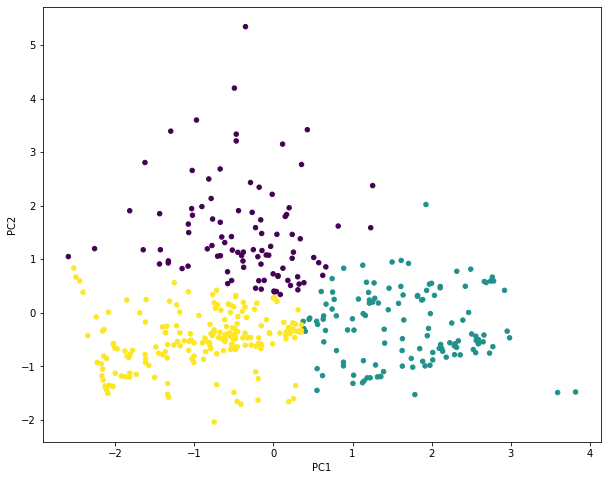

In [26]:
plt.figure(figsize=(10,8))
plt.scatter(data.PC1, data.PC2, c=model.labels_, s=20)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

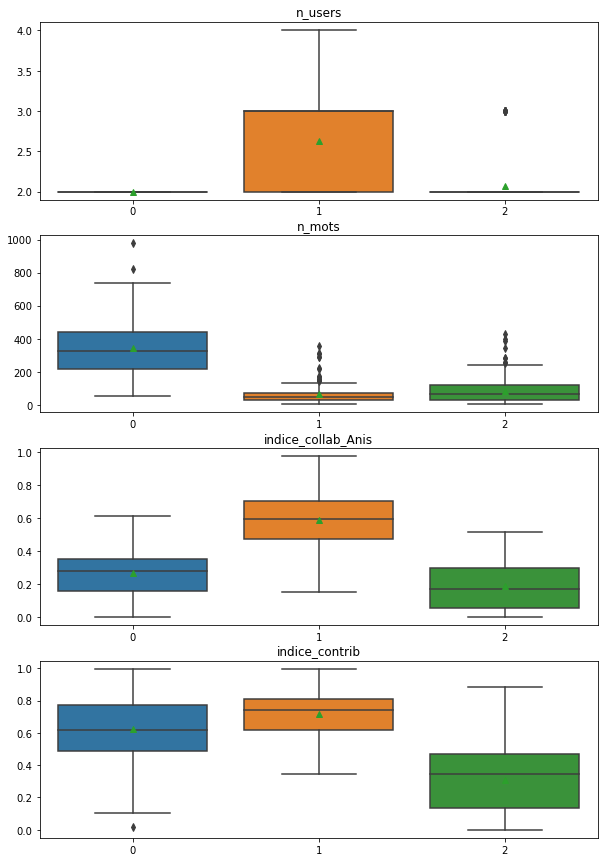

In [27]:
# Pour variables on construit la boix a moustache de chaque classe
fig, ax = plt.subplots(len(X.columns[:-1]), 1, figsize=(10, 15))

id_class = [X.loc[X["labels"] == i].index for i in range(n_clusters)]
for i, var in enumerate(X.columns[:-1]):
    sns.boxplot(data=[X[var].loc[id_class[j]] for j in range(
        n_clusters)], orient="v", showmeans=True, ax=ax[i]).set_title(var)
    #print(i)
plt.show()


On remarque que : 
* Dans la classe ou i l y a des labdocs de longueur petite est celle ou les indicateurs sont les plus élevées (curieux !)
* L'indice de contribution est toujours au-dessus de l'indice de collaboration. La différence entre les deux est proportionnelle à la taille du labdoc 

# Agglomerative clustering 

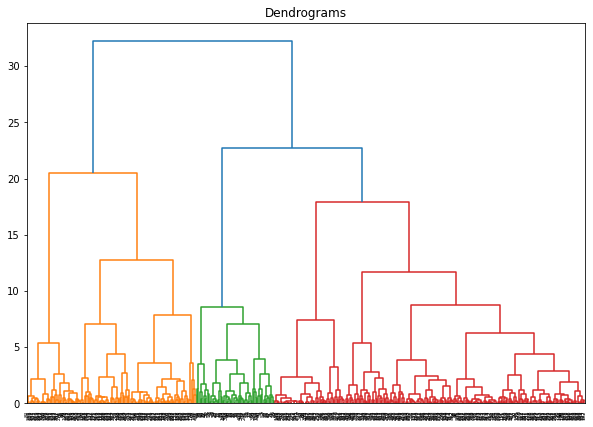

In [28]:
plt.figure(figsize=(10, 7))
plt.title("Dendrograms")
dend = shc.dendrogram(shc.linkage(X_std, method='ward'))

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

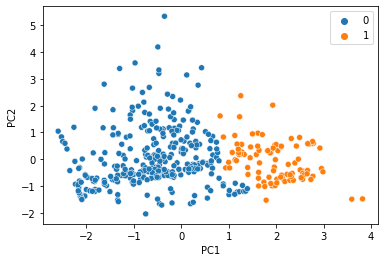

In [29]:
n_clusters = 2
model = AgglomerativeClustering(
    n_clusters=n_clusters, affinity='euclidean', linkage='ward')
labels = model.fit_predict(data)
X["labels"] = labels
sns.scatterplot(x=data['PC1'], y=data['PC2'], hue=labels)

# plt.figure(figsize=(10, 8))
# sns.scatterplot(x=X['n_mots'], y=X['indice_collab_Anis'],
#                 hue=labels, style=labels, palette="deep")


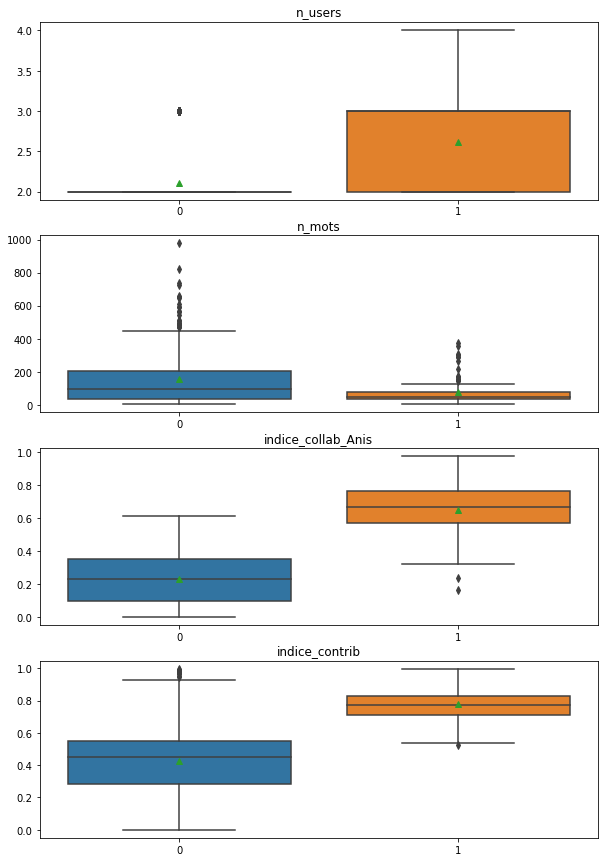

In [30]:
# Pour variables on construit la boix a moustache de chaque classe
fig, ax = plt.subplots(len(X.columns[:-1]), 1, figsize=(10, 15))
id_class = [X.loc[X["labels"] == i].index for i in range(n_clusters)]
for i, var in enumerate(X.columns[:-1]):
    sns.boxplot(data=[X[var].loc[id_class[j]] for j in range(
        n_clusters)], orient="v", showmeans=True, ax=ax[i]).set_title(var)
   # print(i)
plt.show()


Remarques : 
* Comme le jeu de données contien beaucoup de valeurs aberrantes le clustering n'est pas pertinent 
* Aussi, le jeu de données est déséquilibré dans le sens ou il contient presque 75% de labdocs avec deux utilisateurs. Il faudrait peut-être enlever cette variable
* Pour un meilleur clustering, je pense qu'on devrait rajouter d'autre variable comme l'indice de coécriture ou bien le nombre de trace 
* L'ACP n'est fiable à mon avis, car les variables ne sont pas gaussien et aussi ils ne sont peut être pas linéairement séparable. Il faudrait peut être voir d'autres méthodes de réduction de dimension


#TODO
* Récupéré plus de labdocs
* Essayer une méthode non linéaire de réduction de dimension
* Enlever les valeurs aberrantes 
* Implémenter d'autres  algorithmes de Clustering et comprend le 'DBSCAN


# Nouvelle approche 
* ACP à de l'intéret que si les variables sont dépendantes. Voir comment on fait pour détecter la dépendence des variables
